Загрузку данных делаю через api kaggle

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c riiid-test-answer-prediction

100% 1.29G/1.29G [00:19<00:00, 93.5MB/s]
100% 1.29G/1.29G [00:19<00:00, 70.5MB/s]


In [5]:
!unzip riiid-test-answer-prediction

Archive:  riiid-test-answer-prediction.zip
  inflating: example_sample_submission.csv  
  inflating: example_test.csv        
  inflating: lectures.csv            
  inflating: questions.csv           
  inflating: riiideducation/__init__.py  
  inflating: riiideducation/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: train.csv               


In [6]:
import pandas as pd
import numpy as np

## Загрузка данных

Так как файл train.csv достатчоно крупный, то возьмем только 10 миллионов строк и определим типизацию с пониженным количество битов на целые значения, чтобы экономить память.

In [7]:
data_types_dict = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

Загружаем наши датасеты и смотрим на данные

In [104]:
questions_df = pd.read_csv("/content/questions.csv")
lectures_df = pd.read_csv("/content/lectures.csv")
train_df = pd.read_csv("/content/train.csv", nrows=10**7, dtype=data_types_dict, index_col = 0)

In [9]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [10]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


Теги можно будет доопределить до списков

In [11]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Как видим, в информации по вопросам 13523 компонентов, а по лекциям 418

In [58]:
print(train_df.shape)
print(questions_df.shape)
print(lectures_df.shape)

(10000000, 9)
(13523, 5)
(418, 4)


Посчитаем количество уникальных тегов у датасета questions/csv

## Анализ датасета train.csv

Посчитаем общий процент правильных ответов

In [63]:
correct_answers_rate = train_df["answered_correctly"].mean()
print(f"Процент правильно отвеченных вопросов: {correct_answers_rate * 100:.2f}%")

Процент правильно отвеченных вопросов: 62.62%


Посчитаем среднее значение времени, которое тратит студент на один вопрос

In [64]:
# не забудем перевести в секунды
mean_time = train_df["prior_question_elapsed_time"].mean() / 1000
print(mean_time)

25.47559765625


Как видно в среднем студент тратит 25 секунд на ответ

Теперь посмотрим как изменился неправильный ответ на правильный после объяснения

In [16]:
# сгруппируем по столбцу prior_question_had_explanation
explanation_correct = train_df.groupby("prior_question_had_explanation")["answered_correctly"].mean()
print(explanation_correct)

prior_question_had_explanation
False    0.235064
True     0.674771
Name: answered_correctly, dtype: float64


Можно сделать вывод, что в 67% случаев после объянения темы после неправильного ответа, студент отвечает правильно

Теперь рассмотрим распределение пользователей по правилдьности ответов

<Axes: title={'center': 'Распределение пользователей по средней правильности ответов'}, xlabel='процент правильности ответов', ylabel='кол-во пользователей'>

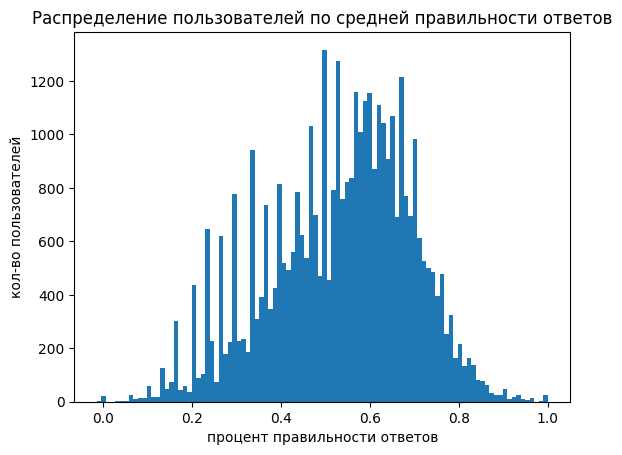

In [84]:
grouped_by_user_df = train_df.groupby("user_id")
user_answers_df = grouped_by_user_df.agg({"answered_correctly": ["mean", "count"] })

user_answers_df[("answered_correctly","mean")].plot.hist(bins = 100, title="Распределение пользователей по средней правильности ответов", xlabel="процент правильности ответов", ylabel="кол-во пользователей")

Выглядит достаточно шумновато и сложно понять что-то по такому распределению. Давайте рассматривать таких пользователей, у которых правильных ответов больше 50, чтобы сгладить распределение

<Axes: title={'center': 'Распределение пользователей по средней правильности ответов'}, xlabel='процент правильности ответов', ylabel='кол-во пользователей'>

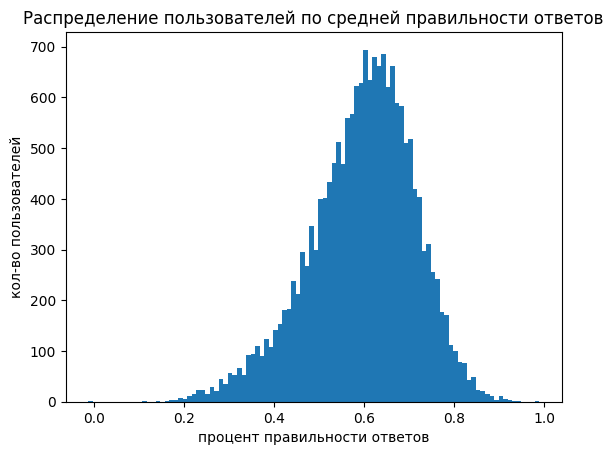

In [87]:
user_answers_df[user_answers_df[("answered_correctly","count")] >= 50][("answered_correctly","mean")].plot.hist(bins = 100, title="Распределение пользователей по средней правильности ответов", xlabel="процент правильности ответов", ylabel="кол-во пользователей")

Мы видим, что у активных пользователей результаты намного лучше, чем у новичков. Но в любом случае средний балл пользователей ниже, чем общий процент правильных ответов. Это означает, что у активных пользователей результаты еще выше.

Построим также распределение по content_id

<Axes: title={'center': 'Распределение вопросов по средней правильности ответов'}, xlabel='процент правильности ответов', ylabel='кол-во вопросов'>

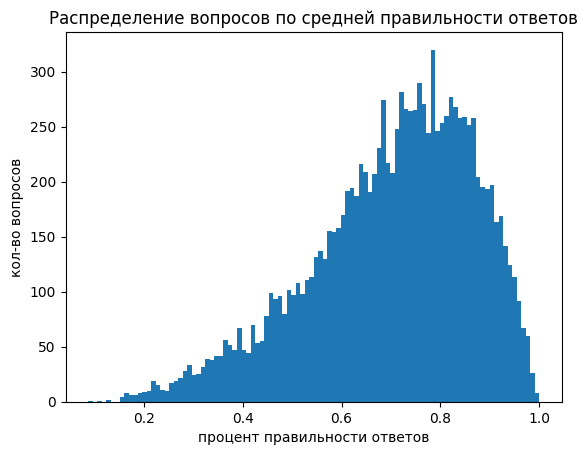

In [89]:
# Уберем строки содержащие информацию только по лекциям и оставим вопросы
train_questions_only_df = train_df[train_df["answered_correctly"]!=-1]
grouped_by_content_df = train_questions_only_df.groupby("content_id")
content_answers_df = grouped_by_content_df.agg({"answered_correctly": ["mean", "count"] })
content_answers_df[content_answers_df[("answered_correctly","count")]>50][("answered_correctly","mean")].plot.hist(bins = 100, title="Распределение вопросов по средней правильности ответов", xlabel="процент правильности ответов", ylabel="кол-во вопросов")

По общему расперделению видно, что большая часть вопросов отвечается правильно пользователями

## Анализ датасета questions.csv

In [111]:
# Переведм снача теги из object в строки
questions_df["tags"] = questions_df["tags"].astype(str)

# Разделим строки в списки по пробелу
tags = [x.split() for x in questions_df[questions_df.tags != "nan"].tags.values]
# Приведем список списков в один список
tags = [item for elem in tags for item in elem]
# И возьмем уникальные значения через set
tags = list(set(tags))
len(tags)

188

Как видно в наших данных 188 уникальных тегов

Сделаем анализ тегов вопросов на которые пользователи отвечают в большинстве случаев и наоборот

In [112]:
# Формируем список тегов
tags_list = [x.split() for x in questions_df["tags"].values]
questions_df["tags"] = tags_list

# Исключим строки, связанные с лекциями, сгруппируем по content_id и правильности ответов, и посчитаем их
correct = train_df[train_df["answered_correctly"] != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
# Сделаем сводную таблицу по правильности ответов и их количества
correct = correct.pivot(index="content_id", columns="answered_correctly", values="size")
# Декомпозируем столбец answered_correctly и сделаем подсчеты правильных и неправильных ответов
correct.columns = ["Wrong", "Right"]
correct = correct.fillna(0)
# Добавим эту информацию в сет questions.csv
w_r_questions_df = questions_df.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
w_r_questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",63.0,628.0
1,1,1,1,1,"[131, 36, 81]",77.0,649.0
2,2,2,0,1,"[131, 101, 162, 92]",1970.0,2531.0
3,3,3,0,1,"[131, 149, 162, 29]",500.0,1776.0
4,4,4,3,1,"[131, 5, 162, 38]",1173.0,1980.0


Теперь для каждого тега из полученного раннее tags посчитаем общее количество правильных и неправльных ответов на вопросы, а также общий процент правильности

In [113]:
tags_df = pd.DataFrame()
# Для каждого тега
for x in range(len(tags)):
    # Берем из общей верхней таблицы те строки, где данный тег присутствует в списке тегов
    df = w_r_questions_df[w_r_questions_df["tags"].apply(lambda l: tags[x] in l)]
    # Аггрегируем суммы
    df1 = df.agg({"Wrong": ["sum"], "Right": ["sum"]})
    # Считаем общее кол-во вопросов
    df1["Total_questions"] = df1["Wrong"] + df1["Right"]
    # Считаем кол-во строк, которые нашли с этим тегом
    df1["Question_ids_with_tag"] = len(df)
    df1["tag"] = tags[x]
    df1 = df1.set_index("tag")
    # Прикрепляем полученные строки к общей таблице
    tags_df = pd.concat([tags_df, df1])

# Переводим типы
tags_df[["Wrong", "Right", "Total_questions"]] = tags_df[["Wrong", "Right", "Total_questions"]].astype(int)
# Считаем процент правильности
tags_df["Percent_correct"] = tags_df["Right"]/tags_df["Total_questions"]
# Сортируем по проценту правильности
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,15523,9653,25176,17,0.383421
23,25673,20228,45901,11,0.440688
19,17267,13833,31100,57,0.444791
151,26954,25882,52836,16,0.489855
108,23213,23511,46724,20,0.503189


Теперь построим столбчатую диаграмму, где будут 10 первых(с наименьшим процентом правильности) и 10 последних(с наибольшим процентом правильности) тегов

<Axes: title={'center': "Десять 'лучших' и 'худших' тегов"}, xlabel='tag'>

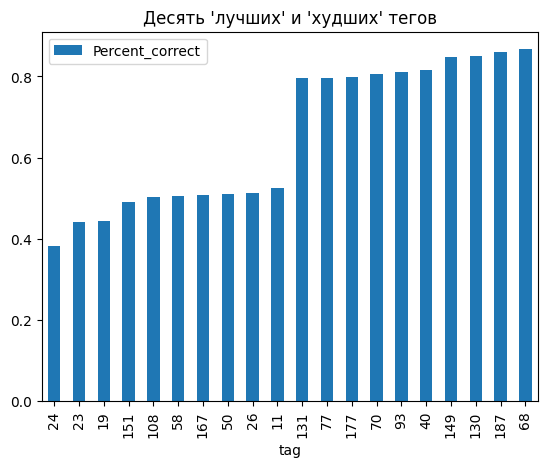

In [115]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4].to_frame()

tags_select.plot.bar(title="Десять 'лучших' и 'худших' тегов")


Из диаграммы видно, что теги 24 23 19 151 108 58 167 50 26 11 имеют меньше всего правильных ответов,
а теги 131 77 177 70 93 40 149 130 187 68 имеют больше всего правильных ответов

Выведем топ 30 тегов по общему количеству вопросов

<Axes: title={'center': 'топ 30 тегов по общему кол-ву вопросов'}, xlabel='tag'>

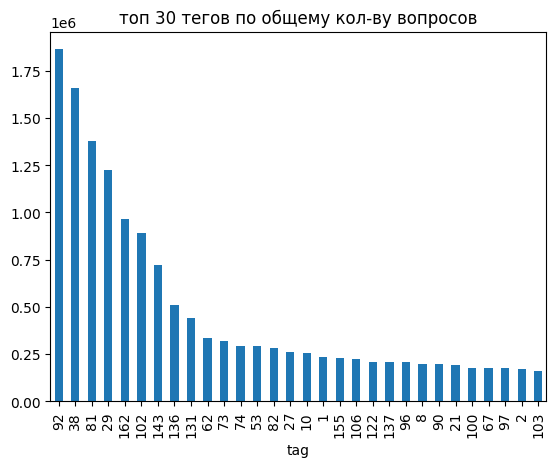

In [116]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]

tags_select.plot.bar(title="топ 30 тегов по общему кол-ву вопросов")

Больше всего вопросов с тегом 92

## Анализ датасета lectures.csv

Посмотрим на характеристику type_of

<Axes: title={'center': 'Количество лекций по type_of'}, xlabel='type_of'>

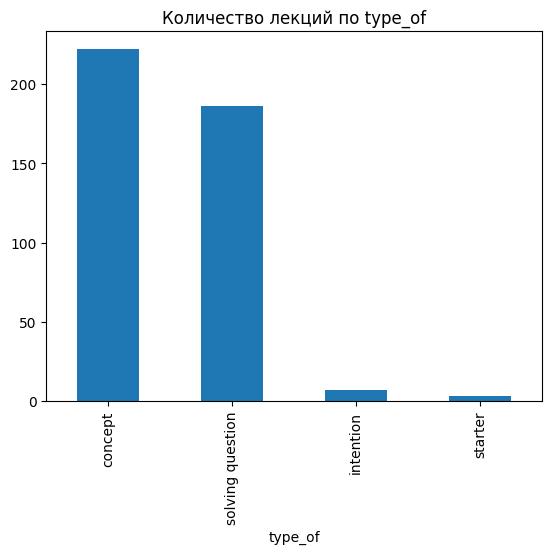

In [117]:
lect_type_of = lectures_df["type_of"].value_counts()
lect_type_of.plot.bar(title="Количество лекций по type_of")

Отсюда можно сделать вывод, что больше всего лекций по type_of у "concept" и "solving question", а мегьше всего у "intention" и "starter"

Теперь проведем анализ того, как влияет правильность ответов пользователей на то, смотрел ли этот пользователь хотя бы одну лекцию или нет

<Axes: title={'center': 'Пользователь, смотревший лекции и процент правильности'}, xlabel='Процент правильности', ylabel='Пользователь смотрел хотя бы одну лекцию'>

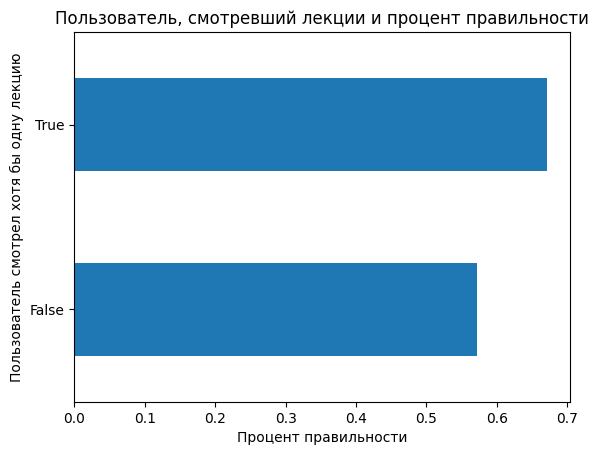

In [121]:
# Сгруппируем по user_id и "answered_correctly"
user_lect = train_df.groupby(["user_id", "answered_correctly"]).size().unstack()
# Отделим значения лекции, неправильно и правильно по -1 0 и 1
user_lect.columns = ["Lecture", "Wrong", "Right"]
user_lect["Lecture"] = user_lect["Lecture"].fillna(0)
user_lect = user_lect.astype("Int64")
# Сделаем условие, что пользователь смотрел хотя бы одну лекцию и отметим это в таблице
user_lect["Watches_lecture"] = np.where(user_lect["Lecture"] > 0, True, False)
# Сгруппируем по этой новой характеристике и посчитаем правильные и неправильные ответы
watches_l = user_lect.groupby("Watches_lecture").agg({"Wrong": ["sum"], "Right": ["sum"]})

# Подсчитаем процент правильности
watches_l['Percent_correct'] = watches_l["Right"]/(watches_l["Right"] + watches_l["Wrong"])

watches_l = watches_l.iloc[:,2]

watches_l.plot.barh(title="Пользователь, смотревший лекции и процент правильности", xlabel="Процент правильности", ylabel="Пользователь смотрел хотя бы одну лекцию")

По данному графику можно сделать вывод, что студенты, смотревшие лекции, имеют больший процент правильных ответов по сравнению с теми, кто не смотрел лекции